In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Documents/AML Final Project/data/cleaned_merged_seasons_final.csv")

In [3]:
data.head()

,season,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,West Ham,0,0,0,0,0.0,454,...,2.0,0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,Everton,0,0,6,0,0.3,142,...,1.0,0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,Arsenal,0,0,5,0,4.9,16,...,3.0,23,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,Watford,0,0,0,0,0.0,482,...,1.0,0,0,0,0,0,50,False,0,1
4,2016-17,Abel Hernández,FWD,Hull,1,0,10,0,12.2,163,...,2.0,30,5,0,0,0,60,True,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152473 entries, 0 to 152472
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   season             152473 non-null  object 
 1   name               152473 non-null  object 
 2   position           152473 non-null  object 
 3   team               152473 non-null  object 
 4   assists            152473 non-null  int64  
 5   bonus              152473 non-null  int64  
 6   bps                152473 non-null  int64  
 7   clean_sheets       152473 non-null  int64  
 8   creativity         152473 non-null  float64
 9   element            152473 non-null  int64  
 10  fixture            152473 non-null  int64  
 11  goals_conceded     152473 non-null  int64  
 12  goals_scored       152473 non-null  int64  
 13  ict_index          152473 non-null  float64
 14  influence          152473 non-null  float64
 15  kickoff_time       152473 non-null  object 
 16  mi

In [5]:
# Add a binary home_advantage column
data['home_advantage'] = data['was_home'].astype(int)

# Add a 'form' column (average points over the last 5 Gameweeks per player)
data['form'] = data.groupby('name')['total_points'].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)

# Ensure only numeric columns for correlation analysis
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation matrix
correlation_matrix = data[numeric_columns].corr()

# Correlation of all features with total_points
correlation_with_points = correlation_matrix['total_points'].sort_values(ascending=False)

# Display top 12 features correlated with total_points
top_12_features = correlation_with_points.index[1:13]  # Exclude 'total_points' itself
print("Top 12 features most correlated with total_points:")
print(correlation_with_points.loc[top_12_features])

Top 12 features most correlated with total_points:
bps             0.901129
influence       0.816862
bonus           0.753718
ict_index       0.744214
goals_scored    0.671941
form            0.644629
minutes         0.599299
clean_sheets    0.566030
threat          0.533498
assists         0.450912
creativity      0.440760
value           0.267536
Name: total_points, dtype: float64


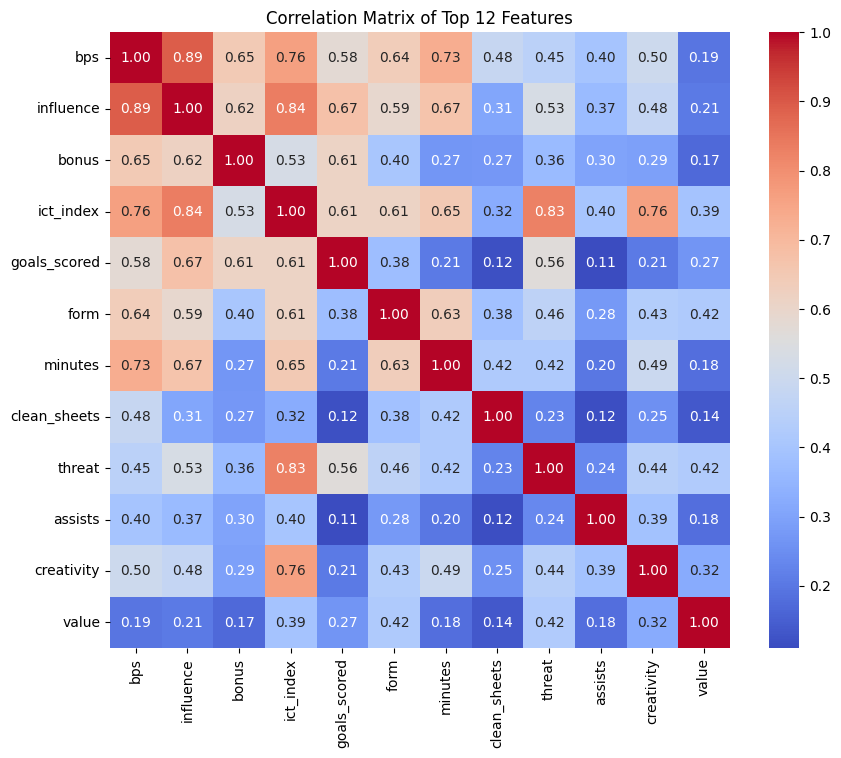

In [6]:
# Plot heatmap for top 12 features
plt.figure(figsize=(10, 8))
sns.heatmap(
    data[top_12_features].corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    cbar=True
)
plt.title("Correlation Matrix of Top 12 Features")
plt.show()

In [7]:
# Define the features to be used
features = ['bps', 'influence', 'bonus', 'ict_index', 'goals_scored',
            'minutes', 'clean_sheets', 'threat', 'assists', 'creativity', 'value', 'form']

In [8]:
def prepare_combined_features(data, features, season, gw, current_window=7):
    """
    Prepares combined historical and current data for a specific gameweek prediction.
    Historical: All data up to the gameweek before the current one.
    Current: Data from the last `current_window` gameweeks of the current season.
    """
    # Historical Data
    historical_data = data[
        (data['season'] < season) | 
        ((data['season'] == season) & (data['GW'] < gw))
    ]
    historical_features = historical_data[features].mean()

    # Current Data (last `current_window` GWs)
    current_data = data[
        (data['season'] == season) & 
        (data['GW'] >= max(1, gw - current_window)) & 
        (data['GW'] < gw)
    ]
    current_features = current_data[features].mean()

    # Combine historical (30%) and current (70%) data
    combined_features = (0.3 * historical_features) + (0.7 * current_features)
    return combined_features

In [9]:
def prepare_gameweek_data(data, features):
    """
    Prepares the dataset for model training and testing by combining historical 
    and current features with respective weights.
    """
    data = data.sort_values(by=['season', 'GW', 'name'])
    result = []

    for (season, player), group in data.groupby(['season', 'name']):
        group = group.copy()
        for gw in range(8, group['GW'].max() + 1):  # Start from GW 8
            historical_data = group[group['GW'] < gw][features]
            current_data = group[(group['GW'] >= gw - 7) & (group['GW'] < gw)][features]
            current_row = group[group['GW'] == gw]

            if not historical_data.empty and not current_data.empty and not current_row.empty:
                historical_features = historical_data.mean()
                current_features = current_data.mean()

                # Weighted combination of Historical and Current
                combined_features = 0.3 * historical_features + 0.7 * current_features
                combined_features['GW'] = gw
                combined_features['season'] = season
                combined_features['total_points'] = current_row.iloc[0]['total_points']
                combined_features['minutes'] = current_row.iloc[0]['minutes']
                combined_features['name'] = player  # Add player name for identification
                result.append(combined_features)

    return pd.DataFrame(result)

In [40]:
def predict_captains(data, features, model, season, max_gw=None, single_gw=None, current_window=7, top_n=5):
    """
    Predicts captains and vice-captains for one or multiple gameweeks in a season and calculates accuracy.

    Parameters:
    - data: DataFrame containing player data.
    - features: List of feature column names.
    - model: Trained machine learning model.
    - season: Current season being analyzed.
    - max_gw: Maximum gameweek number to analyze (if applicable).
    - single_gw: Specific gameweek to analyze (optional).
    - current_window: Number of previous gameweeks to use for historical data.
    - top_n: Number of top players to include in ranking-based evaluation.

    Returns:
    - List of results for each gameweek with accuracy evaluation.
    """
    def calculate_accuracy(predicted_points, actual_points, top_ranked_players=None, predicted_player=None):
        """
        Calculates accuracy based on actual points and optional ranking-based evaluation.

        Parameters:
        - predicted_points (float): Points predicted for the selected captain.
        - actual_points (float): Actual points scored by the captain.
        - top_ranked_players (list): List of top N players based on actual points (optional).
        - predicted_player (str): Name of the predicted player (optional).

        Returns:
        - accuracy (float): Calculated accuracy percentage.
        """
        # Closeness evaluation (predicted vs actual points)
        if actual_points > predicted_points:
            accuracy = 100.0
        elif abs(predicted_points - actual_points) <= 2:
            accuracy = 100.0
        elif abs(predicted_points - actual_points) <= 4:
            accuracy = 70.0
        elif abs(predicted_points - actual_points) <= 6:
            accuracy = 50.0
        else:
            accuracy = 30.0

        # Ranking-based evaluation (if ranking information is provided)
        if top_ranked_players and predicted_player in top_ranked_players:
            accuracy += 20.0  # Add bonus for being in top ranks

        return min(100.0, accuracy)  # Cap accuracy at 100%

    results = []

    # Determine the range of gameweeks to process
    if single_gw is not None:
        gw_range = [single_gw]
    else:
        gw_range = range(8, max_gw + 1)  # Start from GW 8 to include sufficient historical data

    for gw in gw_range:
        try:
            # Prepare combined features for this gameweek
            combined_features = prepare_combined_features(data, features, season=season, gw=gw, current_window=current_window)

            # Filter data for the specific gameweek and season
            gw_data = data[(data['GW'] == gw) & (data['season'] == season)]
            if gw_data.empty:
                print(f"Skipping season {season}, GW {gw}: No data available.")
                continue

            # Predict points for all players
            X_gw = gw_data[features]
            gw_data = gw_data.copy()
            gw_data['predicted_points'] = model.predict(X_gw)

            # Get top N players based on actual points for ranking-based evaluation
            top_ranked_players = gw_data.nlargest(top_n, 'total_points')['name'].tolist()

            # Select top two players as captain and vice-captain
            top_two = gw_data.nlargest(2, 'predicted_points')
            captain = top_two.iloc[0]
            vice_captain = top_two.iloc[1]

            # Actual points for both captain and vice-captain
            actual_points_captain = captain['total_points']
            actual_points_vice_captain = vice_captain['total_points']

            # Use vice-captain if captain doesn't play
            if captain['minutes'] == 0:
                actual_points = actual_points_vice_captain
                selected_captain = vice_captain
            else:
                actual_points = actual_points_captain
                selected_captain = captain

            # Calculate accuracy
            predicted_points = selected_captain['predicted_points']
            accuracy = calculate_accuracy(
                predicted_points=predicted_points,
                actual_points=actual_points,
                top_ranked_players=top_ranked_players,
                predicted_player=selected_captain['name']
            )

            # Append results
            results.append({
                'Season': season,
                'GW': gw,
                'Captain': captain['name'],
                'Vice-Captain': vice_captain['name'],
                'Predicted Points (Captain)': captain['predicted_points'],
                'Predicted Points (Vice-Captain)': vice_captain['predicted_points'],
                'Actual Points (Captain)': actual_points_captain,
                'Actual Points (Vice-Captain)': actual_points_vice_captain,
                'Selected Captain': selected_captain['name'],
                'Actual Points (Selected Captain)': actual_points,
                'Accuracy (%)': accuracy,
            })

        except Exception as e:
            print(f"Error predicting for season {season}, GW {gw}: {e}")
    
    return results

In [11]:
# Prepare training and testing data
data_prepared = prepare_gameweek_data(data, features)

train_data = data_prepared[data_prepared['season'].isin(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23'])]
test_data = data_prepared[data_prepared['season'].isin(['2023-24'])]

X_train = train_data[features]
y_train = train_data['total_points']

X_test = test_data[features]
y_test = test_data['total_points']

In [41]:
# Train the model
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predict captains
season = '2023-24'
max_gw = 38
results = predict_captains(data, features, model, season, max_gw=max_gw)

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)
print(results_df)

     Season  GW                    Captain                      Vice-Captain  \
0   2023-24   8             Erling Haaland                    James Maddison   
1   2023-24   9              Mohamed Salah                   Mykhailo Mudryk   
2   2023-24  10         Abdoulaye Doucouré                     Mohamed Salah   
3   2023-24  11             Erling Haaland                    Anthony Gordon   
4   2023-24  12              Mohamed Salah                       Cole Palmer   
5   2023-24  13     Bruno Borges Fernandes                     Mohamed Salah   
6   2023-24  14              Dwight McNeil               Alexis Mac Allister   
7   2023-24  15             Erling Haaland                       Bukayo Saka   
8   2023-24  16               Raúl Jiménez                    Destiny Udogie   
9   2023-24  17              Mohamed Salah           Alexandre Moreno Lopera   
10  2023-24  18     Trent Alexander-Arnold  Matheus Santos Carneiro Da Cunha   
11  2023-24  19              Mohamed Sal

In [38]:
def calculate_mean_accuracy(results):
    """
    Calculates the mean accuracy from the prediction results.

    Parameters:
    - results (list): List of dictionaries containing prediction results with 'Accuracy (%)'.

    Returns:
    - float: Mean accuracy across all gameweeks.
    """
    if not results:
        print("No results available to calculate mean accuracy.")
        return 0.0
    
    accuracies = [result['Accuracy (%)'] for result in results if 'Accuracy (%)' in result]
    if not accuracies:
        print("No accuracy values found in the results.")
        return 0.0

    mean_accuracy = sum(accuracies) / len(accuracies)
    return mean_accuracy

In [42]:
mean_accuracy = calculate_mean_accuracy(results)
print(f"Mean Accuracy for the season: {mean_accuracy:.2f}%")

Mean Accuracy for the season: 58.39%


In [45]:
from os.path import dirname, join

def export_cleaned_data(df):
    """ Function to export merged df into specified folder
    Args:
        path (str): Path of the folder
        filename(str): Name of the file
    """
    filename = 'Captaincy_selection_prediction.csv'
    filepath = join(dirname(dirname("__file__")), 'Documents/AML Final Project/data', filename)
    df.to_csv(filepath, encoding = 'utf-8', index=False)
    return df

In [47]:
# export_cleaned_data(results_df)

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_predictions(results):
    """
    Visualizes predicted vs actual points for captains and vice-captains.

    Parameters:
    - results (list): List of dictionaries containing prediction results.
    """
    df = pd.DataFrame(results)
    
    # Scatter plot: Predicted vs Actual Points
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Predicted Points (Captain)'], df['Actual Points (Captain)'], label='Captain', alpha=0.7)
    plt.scatter(df['Predicted Points (Vice-Captain)'], df['Actual Points (Vice-Captain)'], label='Vice-Captain', alpha=0.7, marker='x')
    plt.plot([0, max(df['Predicted Points (Captain)'])], [0, max(df['Actual Points (Captain)'])], 'r--', label='Perfect Prediction')
    plt.xlabel('Predicted Points')
    plt.ylabel('Actual Points')
    plt.title('Predicted vs. Actual Points for Captains and Vice-Captains')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy over Gameweeks
    plt.figure(figsize=(10, 6))
    plt.plot(df['GW'], df['Accuracy (%)'], marker='o', label='Accuracy')
    plt.xlabel('Gameweek')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Over Gameweeks')
    plt.grid(True)
    plt.legend()
    plt.show()

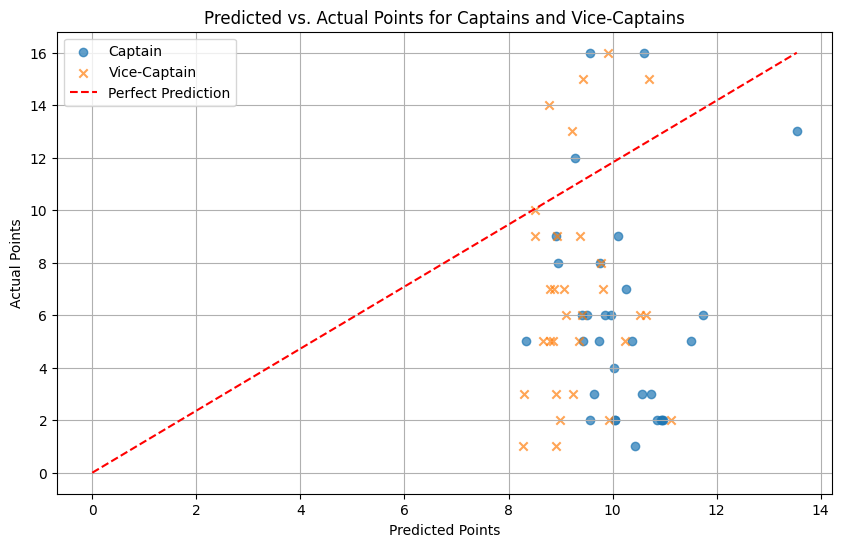

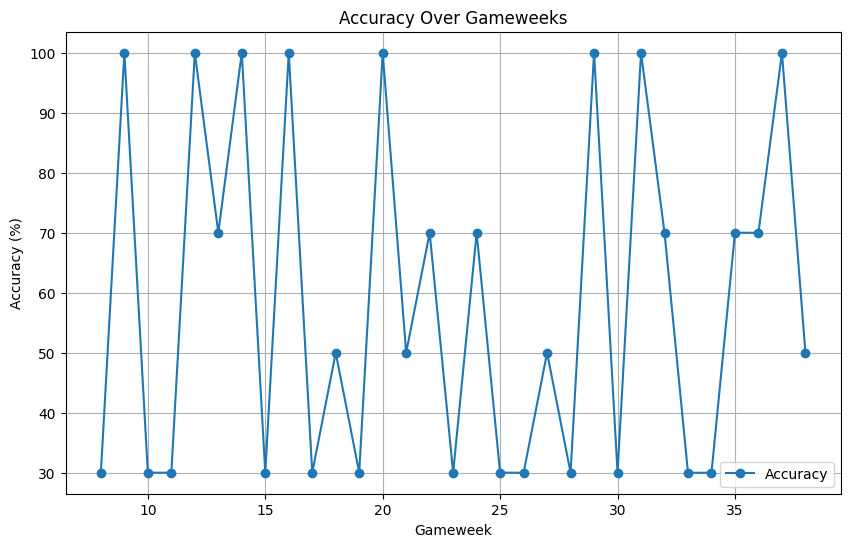

In [56]:
visualize_predictions(results_df)

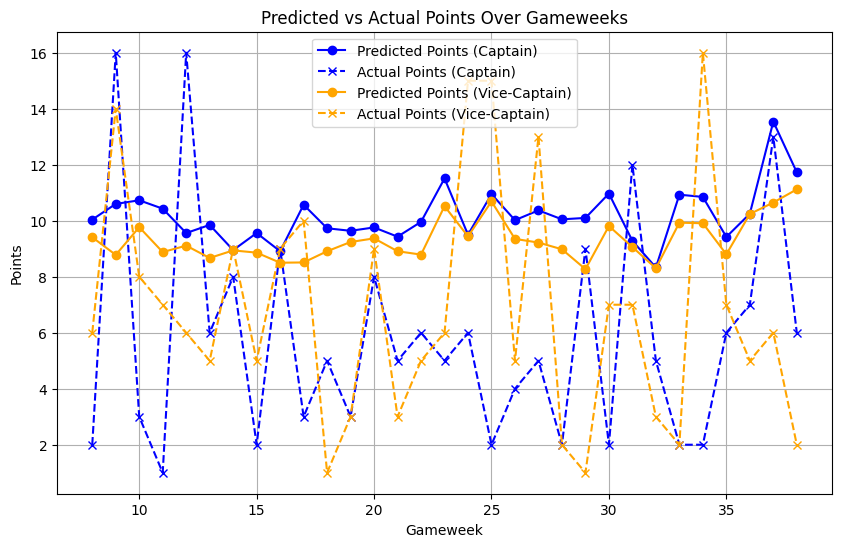

In [57]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame `results_df` containing the columns for actual and predicted points
# for captains and vice-captains across multiple gameweeks.

plt.figure(figsize=(10, 6))

# Plot for Captains
plt.plot(results_df['GW'], results_df['Predicted Points (Captain)'], label='Predicted Points (Captain)', marker='o', color='blue')
plt.plot(results_df['GW'], results_df['Actual Points (Captain)'], label='Actual Points (Captain)', marker='x', color='blue', linestyle='dashed')

# Plot for Vice-Captains
plt.plot(results_df['GW'], results_df['Predicted Points (Vice-Captain)'], label='Predicted Points (Vice-Captain)', marker='o', color='orange')
plt.plot(results_df['GW'], results_df['Actual Points (Vice-Captain)'], label='Actual Points (Vice-Captain)', marker='x', color='orange', linestyle='dashed')

plt.xlabel('Gameweek')
plt.ylabel('Points')
plt.title('Predicted vs Actual Points Over Gameweeks')
plt.legend()
plt.grid(True)
plt.show()

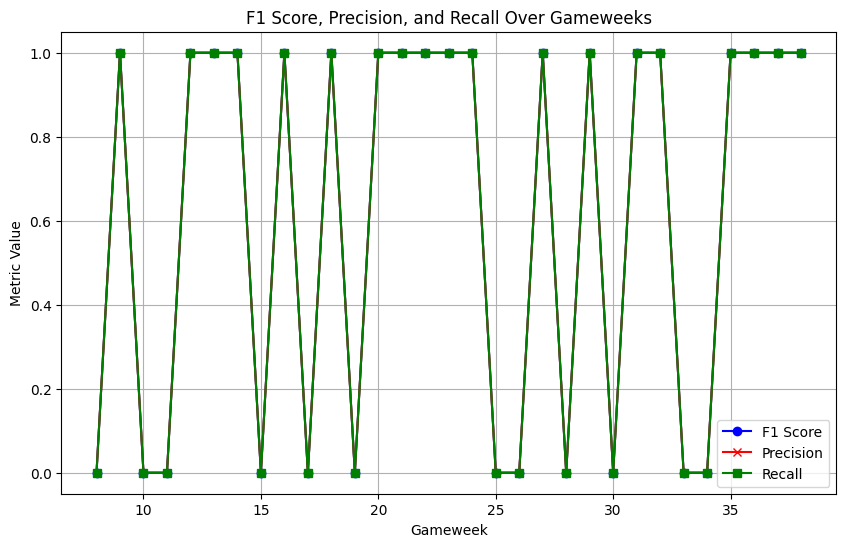

In [59]:
from sklearn.metrics import f1_score, precision_score, recall_score

metrics_per_gw = []

for gw in results_df['GW'].unique():
    gw_data = results_df[results_df['GW'] == gw]
    
    # Predicted and actual binary values (e.g., whether the predicted points match the actual points or not)
    y_true = (gw_data['Actual Points (Captain)'] >= 5).astype(int)  # Assuming "captain with >= 5 points is considered successful"
    y_pred = (gw_data['Predicted Points (Captain)'] >= 5).astype(int)

    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    metrics_per_gw.append({
        'GW': gw,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    })

metrics_df = pd.DataFrame(metrics_per_gw)

plt.figure(figsize=(10, 6))
plt.plot(metrics_df['GW'], metrics_df['F1 Score'], label='F1 Score', marker='o', color='blue')
plt.plot(metrics_df['GW'], metrics_df['Precision'], label='Precision', marker='x', color='red')
plt.plot(metrics_df['GW'], metrics_df['Recall'], label='Recall', marker='s', color='green')

plt.xlabel('Gameweek')
plt.ylabel('Metric Value')
plt.title('F1 Score, Precision, and Recall Over Gameweeks')
plt.legend()
plt.grid(True)
plt.show()


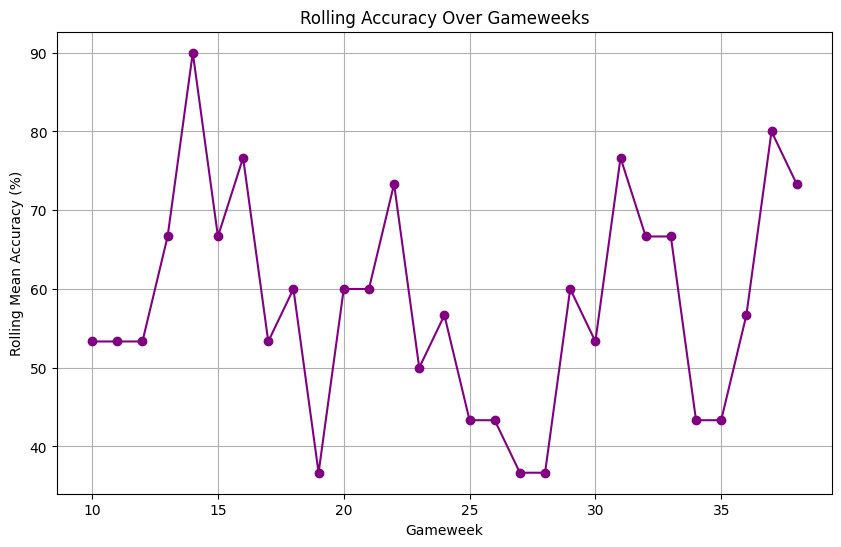

In [60]:
accuracy_df['Rolling Accuracy'] = accuracy_df['Mean Accuracy'].rolling(window=3).mean()

plt.figure(figsize=(10, 6))
plt.plot(accuracy_df['GW'], accuracy_df['Rolling Accuracy'], label='Rolling Accuracy (3-week)', marker='o', color='purple')
plt.xlabel('Gameweek')
plt.ylabel('Rolling Mean Accuracy (%)')
plt.title('Rolling Accuracy Over Gameweeks')
plt.grid(True)
plt.show()
